In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
np.random.seed(42)

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Projection Methods
Build the 3D world

In [51]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 -0.5
X = np.empty((m,3))

X[:,0] = np.cos(angles) + np.sin(angles)/2 + noise*np.random.randn(m) / 2
X[:,1] = np.sin(angles)*0.7 + noise*np.random.randn(m) / 2
X[:,2] = X[:,0]*w1 + X[:,1]*w2 + noise*np.random.randn(m)

# Singular value descomposition

$\textbf{U} \Sigma \textbf{V}^T$

In [52]:
X_centered = X - X.mean(axis=0) # data needs to be centered
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

Projecting down to 2D

In [53]:
W2 = Vt.T[:,:2]
X2D_svd = X_centered.dot(W2)

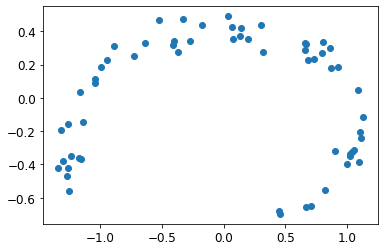

In [54]:
plot(X2D_svd[:,0],X2D_svd[:,1],'o')

# PCA using Scikit-Learn

Now using Scikit-Learn

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

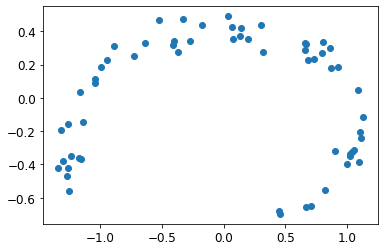

In [56]:
plot(X2D_svd[:,0],X2D_svd[:,1],'o')


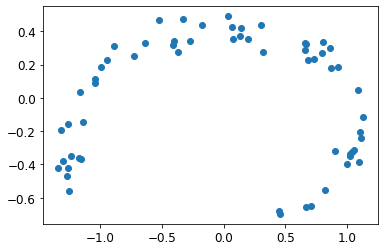

In [59]:
plot(-X2D[:,0],-X2D[:,1],'o')

In [60]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [61]:
X2D_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

To transform back to 3D we can use `inverse_transform`. Remember we lost some information, That can be quantified as shown below

In [62]:
X3D_inv = pca.inverse_transform(X2D)

In [63]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [64]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [65]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

84% of the variance can be explained by the first dimensiont, 14.6% by the second

In [66]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.01017033779284855

We lost 1.01% of the variance when projecting into 2D. 

In [67]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Some utility to make arrows in 3D. Found in  http://stackoverflow.com/questions/11140163

In [68]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [69]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

(-1.0, 1.0)

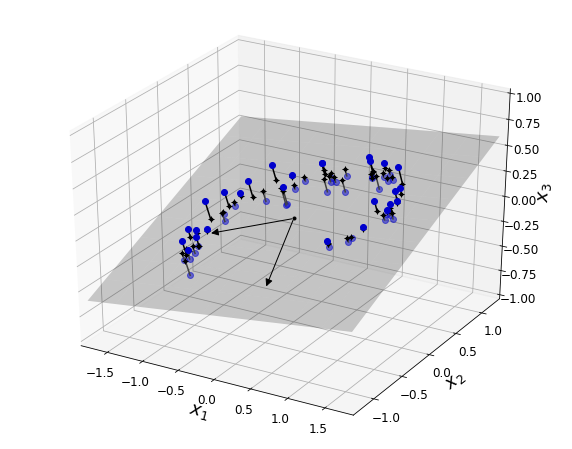

In [72]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")

ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

[-1.5, 1.3, -1.2, 1.2]

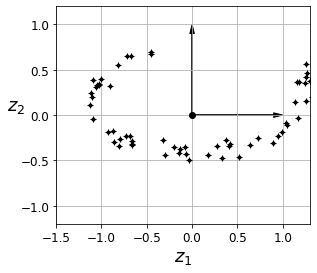

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:,0],X2D[:,1],'k.')
ax.plot(X2D[:,0],X2D[:,1],'k+')
ax.plot(0,0,'ko')
ax.arrow(0,0,0,1,head_width=0.05,length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0,0,1,0,head_width=0.05,length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$",fontsize=18)
ax.set_ylabel("$z_2$",fontsize=18,rotation=0)
ax.grid()
ax.axis([-1.5, 1.3, -1.2, 1.2])

# Manifold Learning

In [88]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000,noise=0.2,random_state=42)

(-12, 15)

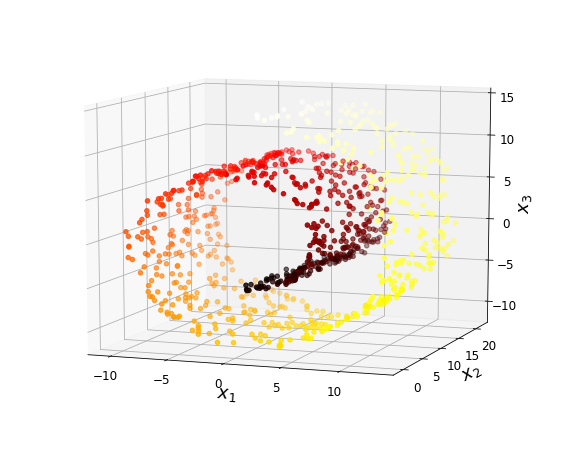

In [95]:
axes = [-11.5, 14, -2, 23 , -12, 15]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(X[:,0],X[:,1],X[:,2], c = t, cmap=plt.cm.hot)
ax.view_init(10,-70)

ax.set_xlabel("$x_1$", fontsize=18,rotation=0)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18,rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

In [96]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

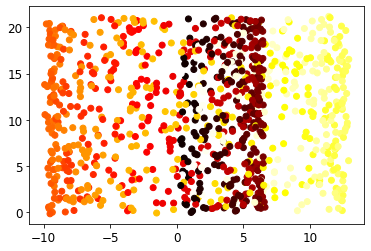

In [106]:
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)

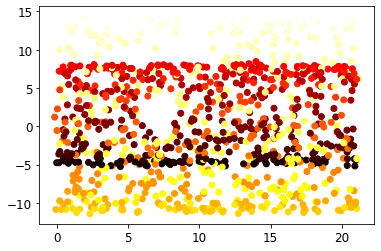

In [105]:
plt.scatter(X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)

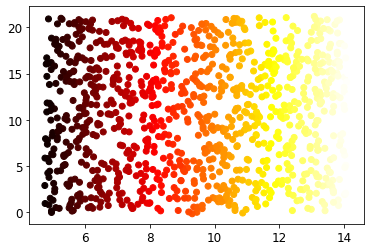

In [104]:
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)

In [111]:
x=np.linspace(1,100,100)

In [114]:
np.sum(x)**2-np.sum(x**2)

25164150.0

In [115]:
np.sum(x**2)

338350.0

In [137]:
999*999

998001